In [1]:
import os, sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from src.infer.object_detector import ObjectDetectModel

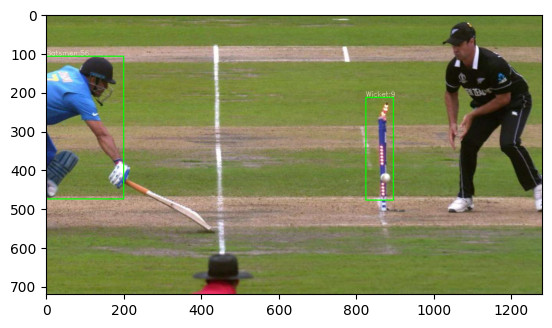

In [2]:
object_detect_model_path = "../../training-jobs/detect/cricket-object-detect17/weights/best.onnx"
# img_path = "../data/Cricket-Semantic-Segmentation[Native]/images/2022-08-24 (13).png"
img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"

model = ObjectDetectModel(object_detect_model_path)
output = model(img_path)
output.show_image()

In [3]:
batsman_box = output.getBoxFromLabel("Batsmen")
wicket_bbx = output.getBoxFromLabel("Wicket")

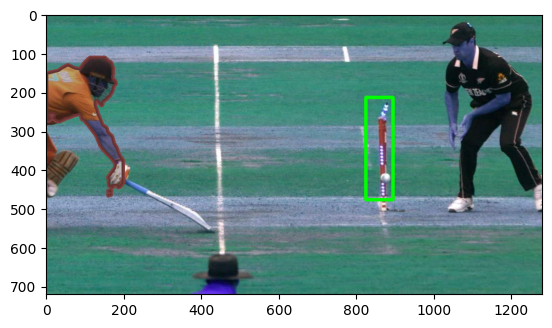

In [4]:
from src.infer.yolo_image_segmentor import ImageSegmentModel
image_segment_model_path = "../../model-weights/yolov8_batsmen_image_segment.onnx"
# Initialize YOLOv8 Instance Segmentator
segmentor = ImageSegmentModel(image_segment_model_path, conf_thres=0.3, iou_thres=0.5)

img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"

# Detect Objects
batsman_seg = segmentor(img_path, batsman_box)

import cv2 as cv
from src.data.visualize import drawSegments, drawRects
img = cv.imread(img_path)
drawn_img = drawSegments(img, [[0, *batsman_seg]])
drawn_img = drawRects(drawn_img, [[1, *wicket_bbx]], False)
plt.imshow(drawn_img)
plt.show()

In [5]:
from src.infer.crease_cross_detector import CreaseCrossDetector
cross_detector = CreaseCrossDetector()
cross_detector(img_path, batsman_seg, wicket_bbx)

False

In [1]:
import os, sys
import matplotlib.pyplot as plt
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from src.infer.pipeline import Pipeline

img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"
object_detect_model_path = "../../training-jobs/detect/cricket-object-detect17/weights/best.onnx"
image_segment_model_path = "../../model-weights/yolov8_batsmen_image_segment.onnx"
classifer_model_path = "../../model-weights/yolov8_batsmen_image_segment.onnx"
batsman_analysis_img_path = "temp/batsman-anaylsis.jpg"


pipe = Pipeline(object_detect_model_path, image_segment_model_path,classifer_model_path)
res = pipe(img_path, batsman_analysis_img_path)


In [2]:
from src.util.file import OutputProcessor
import boto3

s3_client = boto3.client("s3")
op = OutputProcessor(s3_client, "third-umpire-decision-automation-osura")
op(res)

{'annotations': [['Batsman',
   0.0,
   0.15000000596046448,
   0.15625,
   0.6597222089767456],
  ['Wicket',
   0.64453125,
   0.29722222685813904,
   0.699999988079071,
   0.6638888716697693]],
 'batsman_comment': 'False',
 'batsman_analysis_img_s3_uri': 's3://third-umpire-decision-automation-osura/results/74c4c0f0-3fda-4fc9-8de9-5638bd947b9c/batsman-analysis-img.jpg',
 'wicket_comment': 'False',
 'job_id': '74c4c0f0-3fda-4fc9-8de9-5638bd947b9c'}